In [1]:
import tensorflow as tf
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

#config = tf.ConfigProto(gpu_options=tf.GPUOptions(visible_device_list="1", allow_growth=True))

# load a color image with noise
img = imageio.imread('input_DN_butterfly_sig40.png')

N1 = img.shape[0]
N2 = img.shape[1]
C  = img.shape[2]
N3 = img.shape[2]

tau = 6    # window size of delay embedding (patch size)
r   = 36   # dimension of manifold
sig = 0.05 # noise level for denoising auto-encoder


In [2]:
# define functions

# making one-hot filters
def make_embfilter(tau):
    fil = np.zeros([tau,tau,1,tau*tau])
    tij = 0
    for ti in range(tau):
        for tj in range(tau):
            fil[ti,tj,0,tij] = 1
            tij = tij+1
    return fil
Hfil = make_embfilter(tau)
Hfil = Hfil.astype('float32')

pad_para_emb   = [[0,0],[tau-1,tau-1],[tau-1,tau-1],[0,0]]
pad_type_emb   = 'reflect'

# delay-embedding layer
def H(z):
    z = tf.pad(z,pad_para_emb,pad_type_emb)
    return tf.nn.conv2d(z,Hfil,strides=[1,1,1,1],padding='VALID')

# inverse delay-embedding layer
def Hinv(z):
    z_size = np.array(z.shape,dtype='int32')
    Htz = tf.nn.conv2d_transpose(z,Hfil,output_shape=[z_size[0],
                                                      z_size[1]+tau-1,
                                                      z_size[2]+tau-1,
                                                      Hfil.shape[2]],strides=[1,1,1,1],padding='VALID')
    return Htz[:,tau-1:z_size[1],tau-1:z_size[2],:]/tau/tau


## autoencoder (with 3 hidden layer)
def NN(data,ranks):
    Z0 = tf.layers.dense(data,ranks[0])
    Z0 = tf.nn.leaky_relu(Z0)
    Z1 = tf.layers.dense(Z0,ranks[1])
    Z1 = tf.nn.leaky_relu(Z1)
    Z2 = tf.layers.dense(Z1,ranks[2])
    Z2 = tf.nn.leaky_relu(Z2)
    Z3 = tf.layers.dense(Z2,data.shape[1])
    return Z3

In [3]:
## problem def

#dimensions of hidden layers in denoising auto-encoder 
ranks = [8*tau*tau, r, 8*tau*tau]

X  = tf.Variable(tf.random_uniform([C,N2,N1,1], dtype=tf.float32))
Hx=tf.transpose(tf.reshape(tf.transpose(H(X)),[tau*tau,C*(N2+tau-1)*(N1+tau-1)]))
noise= tf.random_normal(Hx.shape,0.0,sig,dtype=tf.float32)
AHx  = NN(Hx+noise,ranks)
Xrec = Hinv(tf.transpose(tf.reshape(tf.transpose(AHx),[tau*tau,N1+tau-1,N2+tau-1,C])))

# reconstructed image
Y  = tf.sigmoid(tf.transpose(tf.layers.conv2d(tf.transpose(Xrec),filters=N3,kernel_size=[1,1],padding="same",strides=(1,1))))

label_node = tf.placeholder(tf.float32,shape=(N3,N2,N1,1))
lam_ph = tf.placeholder(tf.float32,())

rec_loss  = tf.losses.mean_squared_error(label_node,Y)
ae_loss1  = tf.losses.mean_squared_error(Hx, AHx)

ae_loss   = lam_ph/tau/tau*( ae_loss1 )
cost = rec_loss + ae_loss


BATCH_SIZE = 1

batch = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    0.01,                 # Base learning rate.
    batch*BATCH_SIZE,     # Current index into the dataset.
    100,                  # Decay step.
    0.98,                 # Decay rate.
    staircase=True)

update = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step=batch)

init = tf.global_variables_initializer()



Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<IPython.core.display.Javascript object>


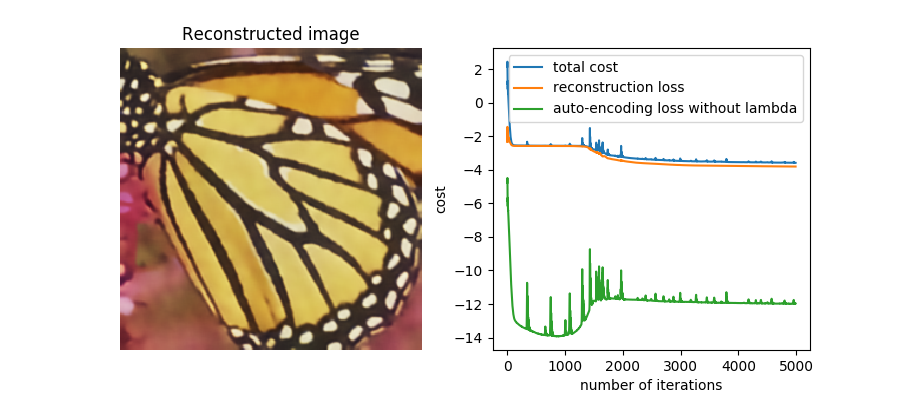

In [4]:
%matplotlib notebook
fig = plt.figure(figsize=(9,4),dpi=100)
ax2 = fig.add_subplot(1,2,1)
ax3 = fig.add_subplot(1,2,2)


In [5]:
import time
import random
import scipy.io

num_iter = 5000
cost_hist = np.zeros([num_iter,3])
start_time = time.time()

sc = 255.0


# reshape
label_data = np.transpose(np.reshape(img.astype(np.float32),[1,N1,N2,N3])/sc)

lam = 1000.0  # initial value of lambda (this should be large in denoising)
with tf.Session(config=config) as sess:
    sess.run(init)
    print('Iinitialized!')
    for step in range(0,num_iter):
        _, cost_value,cost_rec,cost_ae, y_est, x_est = sess.run([update,cost,rec_loss,ae_loss,Y,X],{label_node:label_data,lam_ph:lam})
        l_rate = sess.run(learning_rate)
        cost_hist[step,0] = cost_value
        cost_hist[step,1] = cost_rec
        cost_hist[step,2] = cost_ae/lam
        if step > 100:
            if cost_hist[step,1] > cost_hist[step-100,1]:
                lam = 0.99*lam
        if step %10 == 0:
            elapsed_time = time.time() - start_time
            start_time   = time.time()
            #if cost_rec < cost_ae/lam:
            #lam = np.minimum(lam*1.01, 1000.0)
            #elif cost_ae/lam < cost_rec:
            #    lam = lam*0.99
            print('Step %d / %d :: %f :: %f :: %f' % (step,num_iter,cost_value,l_rate,lam))
            ax2.clear()
            ax2.imshow(np.transpose(np.reshape(255.0*y_est,[3,N2,N1])).astype(np.uint8))
            ax2.set_title("Reconstructed image")
            ax2.axis("off")
            ax3.clear()
            ax3.plot(np.log(cost_hist[0:step,0]), label="total cost")
            ax3.plot(np.log(cost_hist[0:step,1]), label="reconstruction loss")
            ax3.plot(np.log(cost_hist[0:step,2]), label="auto-encoding loss without lambda")
            ax3.legend()
            ax3.set_xlabel("number of iterations")
            ax3.set_ylabel("cost")
            fig.canvas.draw()
imageio.imsave('output_DN.png',np.transpose(np.reshape(255.0*y_est,[3,N2,N1])).astype(np.uint8))

Iinitialized!
Step 0 / 5000 :: 8.572612 :: 0.010000 :: 1000.000000
Step 10 / 5000 :: 2.294231 :: 0.010000 :: 1000.000000
Step 20 / 5000 :: 1.059930 :: 0.010000 :: 1000.000000
Step 30 / 5000 :: 0.533551 :: 0.010000 :: 1000.000000
Step 40 / 5000 :: 0.274615 :: 0.010000 :: 1000.000000
Step 50 / 5000 :: 0.162389 :: 0.010000 :: 1000.000000
Step 60 / 5000 :: 0.115033 :: 0.010000 :: 1000.000000
Step 70 / 5000 :: 0.095394 :: 0.010000 :: 1000.000000
Step 80 / 5000 :: 0.086462 :: 0.010000 :: 1000.000000
Step 90 / 5000 :: 0.082266 :: 0.010000 :: 1000.000000
Step 100 / 5000 :: 0.080149 :: 0.009800 :: 1000.000000
Step 110 / 5000 :: 0.079140 :: 0.009800 :: 1000.000000
Step 120 / 5000 :: 0.078562 :: 0.009800 :: 1000.000000
Step 130 / 5000 :: 0.078270 :: 0.009800 :: 1000.000000
Step 140 / 5000 :: 0.078089 :: 0.009800 :: 1000.000000
Step 150 / 5000 :: 0.077955 :: 0.009800 :: 1000.000000
Step 160 / 5000 :: 0.077842 :: 0.009800 :: 1000.000000
Step 170 / 5000 :: 0.077760 :: 0.009800 :: 1000.000000
Step 18

Step 1510 / 5000 :: 0.061109 :: 0.007386 :: 960.596010
Step 1520 / 5000 :: 0.060399 :: 0.007386 :: 960.596010
Step 1530 / 5000 :: 0.059423 :: 0.007386 :: 960.596010
Step 1540 / 5000 :: 0.069508 :: 0.007386 :: 960.596010
Step 1550 / 5000 :: 0.065416 :: 0.007386 :: 960.596010
Step 1560 / 5000 :: 0.060837 :: 0.007386 :: 960.596010
Step 1570 / 5000 :: 0.058749 :: 0.007386 :: 960.596010
Step 1580 / 5000 :: 0.059447 :: 0.007386 :: 960.596010
Step 1590 / 5000 :: 0.070453 :: 0.007386 :: 960.596010
Step 1600 / 5000 :: 0.063076 :: 0.007238 :: 960.596010
Step 1610 / 5000 :: 0.056936 :: 0.007238 :: 960.596010
Step 1620 / 5000 :: 0.052690 :: 0.007238 :: 960.596010
Step 1630 / 5000 :: 0.052165 :: 0.007238 :: 960.596010
Step 1640 / 5000 :: 0.049841 :: 0.007238 :: 960.596010
Step 1650 / 5000 :: 0.052513 :: 0.007238 :: 960.596010
Step 1660 / 5000 :: 0.053231 :: 0.007238 :: 960.596010
Step 1670 / 5000 :: 0.051781 :: 0.007238 :: 960.596010
Step 1680 / 5000 :: 0.050041 :: 0.007238 :: 960.596010
Step 1690 

Step 3000 / 5000 :: 0.032473 :: 0.005455 :: 960.596010
Step 3010 / 5000 :: 0.031020 :: 0.005455 :: 960.596010
Step 3020 / 5000 :: 0.030922 :: 0.005455 :: 960.596010
Step 3030 / 5000 :: 0.030899 :: 0.005455 :: 960.596010
Step 3040 / 5000 :: 0.030847 :: 0.005455 :: 960.596010
Step 3050 / 5000 :: 0.030780 :: 0.005455 :: 960.596010
Step 3060 / 5000 :: 0.030753 :: 0.005455 :: 960.596010
Step 3070 / 5000 :: 0.030704 :: 0.005455 :: 960.596010
Step 3080 / 5000 :: 0.030699 :: 0.005455 :: 960.596010
Step 3090 / 5000 :: 0.030700 :: 0.005455 :: 960.596010
Step 3100 / 5000 :: 0.030613 :: 0.005346 :: 960.596010
Step 3110 / 5000 :: 0.030627 :: 0.005346 :: 960.596010
Step 3120 / 5000 :: 0.030551 :: 0.005346 :: 960.596010
Step 3130 / 5000 :: 0.030567 :: 0.005346 :: 960.596010
Step 3140 / 5000 :: 0.030622 :: 0.005346 :: 960.596010
Step 3150 / 5000 :: 0.030515 :: 0.005346 :: 960.596010
Step 3160 / 5000 :: 0.030532 :: 0.005346 :: 960.596010
Step 3170 / 5000 :: 0.031023 :: 0.005346 :: 960.596010
Step 3180 

Step 4490 / 5000 :: 0.028488 :: 0.004111 :: 913.517247
Step 4500 / 5000 :: 0.028694 :: 0.004029 :: 913.517247
Step 4510 / 5000 :: 0.028308 :: 0.004029 :: 913.517247
Step 4520 / 5000 :: 0.028360 :: 0.004029 :: 913.517247
Step 4530 / 5000 :: 0.028361 :: 0.004029 :: 913.517247
Step 4540 / 5000 :: 0.028329 :: 0.004029 :: 913.517247
Step 4550 / 5000 :: 0.028335 :: 0.004029 :: 913.517247
Step 4560 / 5000 :: 0.028375 :: 0.004029 :: 913.517247
Step 4570 / 5000 :: 0.029396 :: 0.004029 :: 913.517247
Step 4580 / 5000 :: 0.028165 :: 0.004029 :: 895.338254
Step 4590 / 5000 :: 0.028364 :: 0.004029 :: 895.338254
Step 4600 / 5000 :: 0.028244 :: 0.003948 :: 895.338254
Step 4610 / 5000 :: 0.028129 :: 0.003948 :: 895.338254
Step 4620 / 5000 :: 0.028124 :: 0.003948 :: 895.338254
Step 4630 / 5000 :: 0.028089 :: 0.003948 :: 895.338254
Step 4640 / 5000 :: 0.028113 :: 0.003948 :: 895.338254
Step 4650 / 5000 :: 0.028128 :: 0.003948 :: 895.338254
Step 4660 / 5000 :: 0.028078 :: 0.003948 :: 895.338254
Step 4670 

NameError: name 'Yest_best' is not defined